Epoch 1, Batch  4000, Loss: 2.051
Epoch 1, Batch  6000, Loss: 1.935
Epoch 1, Batch  8000, Loss: 1.821
Epoch 1, Batch 10000, Loss: 1.719
Epoch 1, Batch 12000, Loss: 1.685
Epoch 1 completed, Average Loss: 1.901
Model saved to ./checkpoints_regularized/epoch_1_model.pth
Epoch 2, Batch  2000, Loss: 1.646
Epoch 2, Batch  4000, Loss: 1.608
Epoch 2, Batch  6000, Loss: 1.596
Epoch 2, Batch  8000, Loss: 1.571
Epoch 2, Batch 10000, Loss: 1.575
Epoch 2, Batch 12000, Loss: 1.560
Epoch 2 completed, Average Loss: 1.591
Model saved to ./checkpoints_regularized/epoch_2_model.pth
Epoch 3, Batch  2000, Loss: 1.524
Epoch 3, Batch  4000, Loss: 1.526
Epoch 3, Batch  6000, Loss: 1.515
Epoch 3, Batch  8000, Loss: 1.503
Epoch 3, Batch 10000, Loss: 1.504
Epoch 3, Batch 12000, Loss: 1.513
Epoch 3 completed, Average Loss: 1.514
Model saved to ./checkpoints_regularized/epoch_3_model.pth
Epoch 4, Batch  2000, Loss: 1.461
Epoch 4, Batch  4000, Loss: 1.477
Epoch 4, Batch  6000, Loss: 1.487
Epoch 4, Batch  8000, Loss

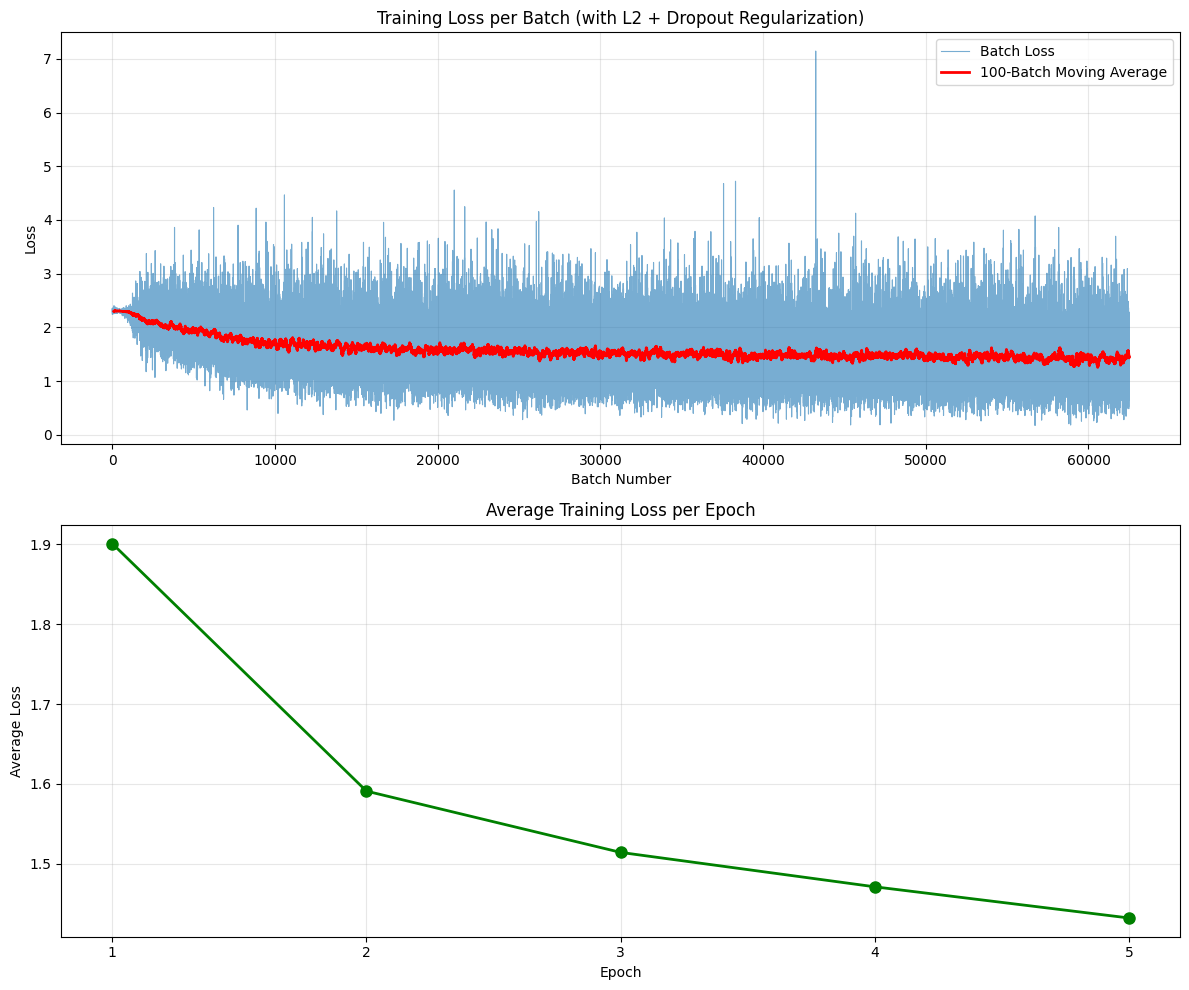


最终模型已保存至: ./checkpoints_regularized/final_model.pth
测试集准确率: 49.49%


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import os

# 设定对图片的归一化处理方式（将RGB值从0-255归一化）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

# 下载数据集
trainset = torchvision.datasets.CIFAR10(root='./dataset', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./dataset', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


# ============================================================================
# 2. 定义用于分类的网络结构（加入Dropout正则化）
# ============================================================================
class Net(nn.Module):
    def __init__(self, dropout_rate=0.5):
        """
        网络结构定义
        
        参数:
            dropout_rate: Dropout层的丢弃概率，默认为0.5
        
        修改说明：
        在第一个全连接层(fc1)和第二个全连接层(fc2)之间加入了Dropout层。
        Dropout会在训练时随机将dropout_rate比例的神经元输出设置为0，
        从而防止神经元之间的共适应(co-adaptation)，提高模型的泛化能力。
        """
        super(Net, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 全连接层
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # *** 新增：Dropout层 ***
        # 在fc1和fc2之间插入Dropout层，训练时随机丢弃50%的神经元
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        # *** 新增：在fc1之后应用Dropout ***
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# ============================================================================
# 3. 模型训练与测试过程（加入L2正则化）
# ============================================================================
def train(trainloader, net, num_epochs, criterion, optimizer, save_path):
    """
    训练函数，记录并可视化损失变化
    
    参数:
        trainloader: 训练数据加载器
        net: 神经网络模型
        num_epochs: 训练轮数
        criterion: 损失函数
        optimizer: 优化器（已配置L2正则化）
        save_path: 模型保存路径
    
    返回:
        loss_history: 包含所有损失值的字典
    """
    # 创建保存路径
    os.makedirs(save_path, exist_ok=True)
    
    # 使用字典记录损失历史
    loss_history = {
        'batch_losses': [],      # 每个batch的损失
        'epoch_losses': [],      # 每个epoch的平均损失
        'batch_indices': []      # batch的索引（用于绘图）
    }
    
    total_batches = 0  # 总batch计数
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0
        num_batches = 0
        
        # 设置为训练模式（dropout生效）
        net.train()
        
        for i, data in enumerate(trainloader, 0):
            # 1. 取出数据
            inputs, labels = data
            
            # 2. 梯度清零
            optimizer.zero_grad()
            
            # 3. 前向计算
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            # 注意：L2正则化已经通过optimizer的weight_decay参数实现
            # 不需要在这里手动添加正则化项
            
            # 4. 反向传播，更新参数
            loss.backward()
            optimizer.step()
            
            # 记录损失
            current_loss = loss.item()
            running_loss += current_loss
            epoch_loss += current_loss
            num_batches += 1
            total_batches += 1
            
            # 记录每个batch的损失
            loss_history['batch_losses'].append(current_loss)
            loss_history['batch_indices'].append(total_batches)
            
            # 每2000个batch打印一次训练状态
            if i % 2000 == 1999:
                avg_loss = running_loss / 2000
                print(f'Epoch {epoch + 1}, Batch {i + 1:5d}, Loss: {avg_loss:.3f}')
                running_loss = 0.0
        
        # 记录每个epoch的平均损失
        avg_epoch_loss = epoch_loss / num_batches
        loss_history['epoch_losses'].append(avg_epoch_loss)
        print(f'Epoch {epoch + 1} completed, Average Loss: {avg_epoch_loss:.3f}')
        
        # 保存模型
        model_path = os.path.join(save_path, f'epoch_{epoch + 1}_model.pth')
        torch.save(net.state_dict(), model_path)
        print(f'Model saved to {model_path}')
    
    print('Finished Training')
    
    # 保存损失历史到文件
    loss_file = os.path.join(save_path, 'loss_history.npz')
    np.savez(loss_file, 
             batch_losses=loss_history['batch_losses'],
             epoch_losses=loss_history['epoch_losses'],
             batch_indices=loss_history['batch_indices'])
    print(f'Loss history saved to {loss_file}')
    
    return loss_history


def predict(testloader, net):
    """
    测试函数，评估模型在测试集上的准确率
    
    参数:
        testloader: 测试数据加载器
        net: 神经网络模型
    
    返回:
        accuracy: 测试集准确率
    """
    correct = 0  # 预测正确的图片数
    total = 0    # 总共的图片数
    
    # 设置为评估模式（Dropout失效/关闭）
    net.eval()
    
    with torch.no_grad():  # 正向传播时不计算梯度
        for data in testloader:
            # 1. 取出数据
            images, labels = data
            # 2. 正向传播，得到输出结果
            outputs = net(images)
            # 3. 从输出中得到模型预测
            _, predicted = torch.max(outputs, 1)
            # 4. 计算性能指标
            total += labels.size(0)
            correct += (predicted == labels).sum()
    
    accuracy = 100 * correct / total
    print('测试集中的准确率为: %d %%' % accuracy)
    return accuracy


def plot_loss(loss_history, save_path):
    """
    可视化损失变化
    
    参数:
        loss_history: 包含损失历史的字典
        save_path: 图表保存路径
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # 绘制每个batch的损失曲线
    axes[0].plot(loss_history['batch_indices'], loss_history['batch_losses'], 
                 alpha=0.6, linewidth=0.8, label='Batch Loss')
    # 添加移动平均线以更清晰地显示趋势
    window_size = 100
    if len(loss_history['batch_losses']) >= window_size:
        moving_avg = np.convolve(loss_history['batch_losses'], 
                                 np.ones(window_size)/window_size, 
                                 mode='valid')
        axes[0].plot(range(window_size-1, len(loss_history['batch_losses'])), 
                     moving_avg, color='red', linewidth=2, 
                     label=f'{window_size}-Batch Moving Average')
    
    axes[0].set_xlabel('Batch Number')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss per Batch (with L2 + Dropout Regularization)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 绘制每个epoch的平均损失
    epochs = range(1, len(loss_history['epoch_losses']) + 1)
    axes[1].plot(epochs, loss_history['epoch_losses'], 
                 marker='o', linewidth=2, markersize=8, color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Average Loss')
    axes[1].set_title('Average Training Loss per Epoch')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xticks(epochs)
    
    plt.tight_layout()
    
    # 保存图表
    plot_path = os.path.join(save_path, 'loss_visualization.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f'Loss visualization saved to {plot_path}')
    plt.show()


# ============================================================================
# 主程序
# ============================================================================
if __name__ == '__main__':
    # 初始化网络（使用Dropout正则化）
    dropout_rate = 0.5  # 可以调整Dropout丢弃率
    net = Net(dropout_rate=dropout_rate)
    print(net)
    print(f'\n使用Dropout正则化，丢弃率: {dropout_rate}')
    
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    
    # *** 修改：使用weight_decay参数实现L2正则化 ***
    # weight_decay即为L2正则化系数λ
    # 优化器会自动在梯度更新时添加 λ * w 项
    l2_lambda = 0.01  # L2正则化系数，可以调整
    optimizer = optim.SGD(net.parameters(), 
                         lr=0.001, 
                         momentum=0.9, 
                         weight_decay=l2_lambda)  # 添加L2正则化
    
    print(f'使用L2正则化，weight_decay: {l2_lambda}\n')
    
    # 训练参数
    num_epochs = 5
    save_path = './checkpoints_regularized'  # 修改为你的保存路径
    
    # 开始训练
    print('='*60)
    print('开始训练（使用L2正则化 + Dropout正则化）')
    print('='*60)
    loss_history = train(trainloader, net, num_epochs, criterion, optimizer, save_path)
    
    # 测试模型
    print('\n' + '='*60)
    print('测试模型性能')
    print('='*60)
    accuracy = predict(testloader, net)
    
    # 可视化损失
    plot_loss(loss_history, save_path)
    
    # 保存最终模型
    final_model_path = os.path.join(save_path, 'final_model.pth')
    torch.save(net.state_dict(), final_model_path)
    print(f'\n最终模型已保存至: {final_model_path}')
    print(f'测试集准确率: {accuracy:.2f}%')